In [1]:
import pandas as pd
import numpy as np
import pandas

In [2]:
# 1. 데이터 가져오기
def load_dataset():
    # 데이터 load
    data = pd.read_csv("data/credit_card_churn.csv", na_values='Unknown')
    # 컬럼명 소문자로 변경
    rename_columns = {
        'Attrition_Flag': 'churn',
        'Customer_Age' : 'age',
        'Dependent_count' : 'dependent_cnt',
        'Months_on_book' : 'card_usage_period',
        'Total_Relationship_Count' : 'account_cnt',
        'Months_Inactive_12_mon' : 'inactive_month_in_year',
        'Contacts_Count_12_mon' : 'visit_cnt_in_year',
        'Total_Revolving_Bal' : 'revolving_balance',
        'Avg_Open_To_Buy' : 'avg_remain_credit_limit',
        'Total_Amt_Chng_Q4_Q1' : 'total_amt_change_q4_q1',
        'Total_Trans_Ct' : 'total_trans_cnt',
        'Total_Ct_Chng_Q4_Q1' : 'total_cnt_change_q4_q1'
    }
    data.rename(columns=rename_columns, inplace=True)
    data.columns = data.columns.str.lower()
    
    ## 불필요 칼럼 삭제
    data.drop(
        columns=[
            'clientnum',
            'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_1',
            'naive_bayes_classifier_attrition_flag_card_category_contacts_count_12_mon_dependent_count_education_level_months_inactive_12_mon_2'
        ], 
        inplace=True
    )
    return data

df = load_dataset()



In [3]:

# 2. 데이터 전처리 (이상치, 결측치, Feature Engineering)

# 2-1. 데이터 전처리 > 이상치(Outlier) 
# - IQR 식별 -> 극단치 제거
#  2-1-1. Outlier 식별: IQR(Inter quantile Range) 을 이용해 Outlier 식별 
def find_outliers(df, column_name, whis=1.5):
    """
    분위수 기준으로 이상치를 찾는 함수

    Parameters:
    df (pd.DataFrame): 데이터프레임
    column_name (str): 이상치를 찾을 컬럼명

    Returns:
    pd.Series: 이상치 값들
    """
    q1, q3 = df[column_name].quantile(q=[0.25, 0.75])
    iqr = q3 - q1
    iqr *= whis
    return df.loc[~df[column_name].between(q1 - iqr, q3 + iqr)]

# ==> ["age", "total_trans_cnt"] 두 칼럼의 이상치를 삭제하기로 결정

#  2-1-2. Outlier 제거: 삭제할 이상치 index를 찾아서 drop
def delete_outliers(df, columns, whis=1.5):
    index_list = []
    _df = df.copy()
    
    for col in columns: 
        outliers_column_index = find_outliers(df, col, whis=whis)
        index_list.extend(outliers_column_index.index)
        
        
    _df = _df.drop(index=index_list)
        
    _df.reset_index(drop=True, inplace=True)
    
    return _df

outlier_columns = ["age", "total_trans_cnt"]
df = delete_outliers(df, outlier_columns)

In [4]:
# 2-2. 데이터 전처리 > 결측치 대체(imputation) 
# - SimpleImputer: 최빈값으로 대치(column 2개) + 사용자 정의 imputer: 비율에 따른 대치(column 1개)
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

#  2-2-1. SimpleImputer(strategy=최빈값) 
simple_imputer = SimpleImputer(strategy='most_frequent')

#  2-2-2. ProportionalImputer(사용자 정의)
class ProportionalImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.fill_values = {}

    def fit(self, X, y=None):
        for column in self.columns:
            value_counts = X[column].value_counts(normalize=True)
            self.fill_values[column] = (value_counts.index, value_counts.values)
        return self

    def transform(self, X):
        X = X.copy()
        for column in self.columns:

            nan_count = X[column].isna().sum()
            if nan_count > 0:
                fill_values = np.random.choice(
                    self.fill_values[column][0], size=nan_count, p=self.fill_values[column][1]
                )
                X.loc[X[column].isna(), column] = fill_values
        return X

def simple_impute_most_frequent(df, columns):
    imputer = SimpleImputer(strategy='most_frequent')
    df[columns] = imputer.fit_transform(df[columns])
    return df
def proportional_impute(df, columns):
    imputer = ProportionalImputer(columns=columns)
    imputer.fit(df)
    return imputer.transform(df)

df = simple_impute_most_frequent(df, ['education_level', 'marital_status'])
df = proportional_impute(df, ['income_category'])

In [5]:
# 2-3. 데이터 전처리 > Feature Engineering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# 2-3-1. 라벨 인코딩(Label Encoding) - 'gender'
# 이유: 이진 변수의 경우 모델 성능에 큰 차이가 없으므로, 간단히 라벨 인코딩을 사용하기로 함.
label_encoder = LabelEncoder()

df['gender'] = label_encoder.fit_transform(df['gender'])

# 2-3-2. 순서 인코딩 (Ordinal Encoding) - 'education_level', 'income_category'
education_order = {"Uneducated": 0, "High School": 1, "College": 2, "Graduate": 3, "Post-Graduate": 4, "Doctorate": 5}
df['education_level'] = df['education_level'].map(education_order)
income_order = {"Less than $40K" : 0, "$40K - $60K" : 1, "$60K - $80K" : 2,"$80K - $120K" :3, "$120K +":4}
df['income_category'] = df['income_category'].map(income_order)

# 2-3-3. mapping - 'churn'
df['churn'] = df['churn'].map({"Existing Customer": 0, "Attrited Customer": 1})

# 2-3-4. 원핫 인코딩(One-Hot encoding) - 'marital_status', 'card_category', 'income_category'
# 이유: 순서가 없고 각 값이 독립적인 범주형 데이터으로서 순서나 크기 정보 없이 각각 독립적인 특성으로 변환되므로, 머신러닝 모델에서 더 잘 해석될 가능성이 있다고 보아 원핫 인코딩 하기로 결정.
ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)

columns_to_ohe_encode = [ 'marital_status', 'card_category']
encoded_data = ohe_encoder.fit_transform(df[columns_to_ohe_encode])

# 인코딩된 데이터를 dataframe으로 변환
encoded_df = pd.DataFrame(encoded_data, columns=ohe_encoder.get_feature_names_out(columns_to_ohe_encode))
# 기존 df와 인코딩된 dataframe을 병합하고 원본 열 삭제
df = pd.concat([df.drop(columns=columns_to_ohe_encode), encoded_df], axis=1)

In [6]:
# 3. 데이터 나누기

# 3-1. featues(X) 과 target(y) 나누기
X = df.drop("churn", axis=1) 
y = df["churn"]

print(df.shape)  # (10123, 26)
print(X.shape)  #(10123, 25)
print(y.shape)  # (10123, )

# 3-2. Trainning set, Testing set 데이터 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

(10123, 23)
(10123, 22)
(10123,)
(8098, 22)
(8098,)


In [7]:
# 4. Machine learning Modeling
# 4-1. 모델 선택하기 
# 전체적으로 어떤 모델이 적합할지 확인하고 주요 모델 4가지를 뽑아 더 자세히 분석하고자 함.
from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier, plot_importance
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
models = { 
    # Logistic Regression model
    "Logistic Regression": LogisticRegression(),
    # Decision Tree model
    "Decision Tree Classifier": DecisionTreeClassifier(),
    # Random Forest model
    "Random Forest": RandomForestClassifier(),
    # Gradient Boosting model
    "Gradient Boosting": GradientBoostingClassifier(),
    # XGBoost model
    "XGBoost": XGBClassifier(),
    # SVM(Support Vector Machine)
    "SVC": SVC(),
    # KNN(K-Nearest Neighbors)
    "KNeighborsClassifier": KNeighborsClassifier(),
}


for name, model in tqdm(models.items(), desc="Training Models", total=len(models)):
    # 모델 훈련
    model.fit(X_train, y_train)
    # 모델 평가
    score = model.score(X_test, y_test)
    # 모델 검증
    model_pred = model.predict(X_test)
    # 모델 정확도
    tqdm.write(f">>> {name} : 정확도 {score:.2%}\n")


# """
# ==================================
# 결과 : 우수한 모델 4가지 출력
# 1. Decision Tree Classifier, 2. Random Forest, 3. Gradient Boosting, 4. XGBoost
# ==================================
# - Decision Tree Classifier: 정확도 93.78%
# - Random Forest: 정확도 95.65%
# - Gradient Boosting: 정확도 96.79%
# - XGBoost: 정확도 97.19%

# """

Training Models:   0%|                                                                           | 0/7 [00:00<?, ?it/s]C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
Training Models:  14%|█████████▌                                                         | 1/7 [00:00<00:02,  2.87it/s]

>>> Logistic Regression : 정확도 87.36%



Training Models:  29%|███████████████████▏                                               | 2/7 [00:00<00:01,  3.23it/s]

>>> Decision Tree Classifier : 정확도 94.67%



Training Models:  43%|████████████████████████████▋                                      | 3/7 [00:04<00:07,  1.94s/it]

>>> Random Forest : 정확도 95.80%



Training Models:  57%|██████████████████████████████████████▎                            | 4/7 [00:11<00:11,  3.96s/it]

>>> Gradient Boosting : 정확도 96.79%



Training Models:  71%|███████████████████████████████████████████████▊                   | 5/7 [00:12<00:05,  2.82s/it]

>>> XGBoost : 정확도 96.89%



Training Models:  86%|█████████████████████████████████████████████████████████▍         | 6/7 [00:19<00:04,  4.17s/it]

>>> SVC : 정확도 83.51%



Training Models: 100%|███████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.91s/it]

>>> KNeighborsClassifier : 정확도 89.04%



In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [9]:
# 여러 평가 지표 설정
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'auc': make_scorer(roc_auc_score)
}

model_box = pd.DataFrame(columns=['decision_tree', 'random_forest', 'gradient_boosting', 'xgboost'],
                         index = ['accuracy','precision','recall','f1 score','auc'])

def evaluate(title, y_real, y_pred, y_prob):
    acc = accuracy_score(y_real, y_pred)
    pre = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)
    
    print(f"======= {title} =======")
    print('Accuracy : {:.6f}'.format(acc)) # 정확도 : 예측이 정답과 얼마나 정확한가
    print('Precision : {:.6f}'.format(pre)) # 정밀도 : 예측한 것 중에서 정답의 비율
    print('Recall : {:.6f}'.format(rec)) # 재현율 : 정답 중에서 예측한 것의 비율
    print('F1 score : {:.6f}'.format(f1)) # 정밀도와 재현율의 (조화)평균 - 정밀도와 재현율이 비슷할수록 높은 점수
    print('auc: {:.6f}'.format(auc))
    
    
    score_list = [acc,pre,rec,f1,auc]
    score_box = np.array(score_list)
    
    return score_box

C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


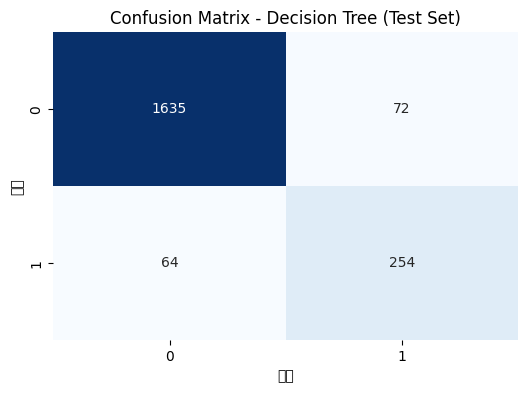

======= Train - Decision Tree =======
Accuracy : 1.000000
Precision : 1.000000
Recall : 1.000000
F1 score : 1.000000
auc: 1.000000
======= Test - Decision Tree =======
Accuracy : 0.932840
Precision : 0.779141
Recall : 0.798742
F1 score : 0.788820
auc: 0.878281


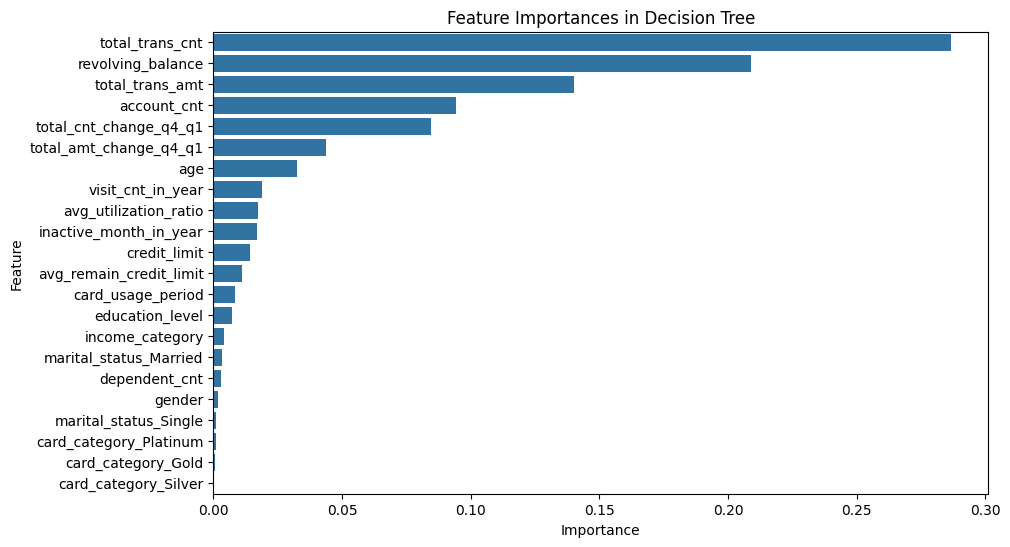

======= Best - Decision Tree =======
Accuracy : 0.945185
Precision : 0.820433
Recall : 0.833333
F1 score : 0.826833
auc: 0.946164


In [10]:
# 4-2. ML 모델별 분석
# 4-2-1. Decision Tree Classifier
"""
====================================================================================
주요 파라미터
====================================================================================
- criterion: 노드 분할 기준
- max_depth: 각 결정 트리의 최대 깊이를 설정
- min_samples_split: 노드를 분할하기 위한 최소 샘플 수
- min_samples_leaf: 리프 노드의 최소 샘플 수
- max_features: 각 트리가 학습할 때마다 사용할 특성(feature)의 수
"""

from sklearn.tree import DecisionTreeClassifier

# 1. 학습 및 예측
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)

# 2. 모델 평가
# Train set + Test set 평가
y_train_pred_tree = tree.predict(X_train)
y_train_proba_tree= tree.predict_proba(X_train)[:, 1]

y_test_pred_tree = tree.predict(X_test)
y_test_proba_tree= tree.predict_proba(X_test)[:, 1]

# 혼동 행렬 시각화 (테스트 데이터)
cm_test = confusion_matrix(y_test, y_test_pred_tree)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("예측")
plt.ylabel("정답")
plt.title("Confusion Matrix - Decision Tree (Test Set)")
plt.show()
 
evaluate("Train - Decision Tree", y_train, y_train_pred_tree, y_train_proba_tree)
evaluate("Test - Decision Tree", y_test, y_test_pred_tree, y_test_proba_tree)

# 3. 특성 중요도 계산 및 시각화
fi = tree.feature_importances_
fi_series = pd.Series(fi, index=df.drop(columns="churn").columns).sort_values(ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=fi_series, y=fi_series.index)
plt.title("Feature Importances in Decision Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 4. 최적의 매개변수 구하기 - GridSearchCV
params = {
    'criterion': ['gini', 'entropy'],  # 노드 분할 기준
    'max_depth': [None, 10, 20, 30],   # 각 결정 트리의 최대 깊이를 설정
    'min_samples_split': [2, 10, 20],  # 노드를 분할하기 위한 최소 샘플 수
    'min_samples_leaf': [1, 5, 10],    # 리프 노드의 최소 샘플 수
    'max_features': [None, 'sqrt', 'log2']  # 각 트리가 학습할 때마다 사용할 특성(feature)의 수
}

gs_tree = GridSearchCV(
    estimator=tree,          
    param_grid=params,  
    scoring=scoring,
    refit='accuracy',
    cv=5,             
    n_jobs=-1,         
)

gs_tree.fit(X_train, y_train)

# 5. Best Model: 최적의 하이파라미터로 만든 모델
best_param_tree = gs_tree.best_params_
best_model_tree = gs_tree.best_estimator_

best_y_pred_tree = best_model_tree.predict(X_test)
best_y_proba_tree= best_model_tree.predict_proba(X_test)[:, 1]

# score 기록 
model_box['decision_tree'] = evaluate("Best - Decision Tree", y_test, best_y_pred_tree, best_y_proba_tree)

C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


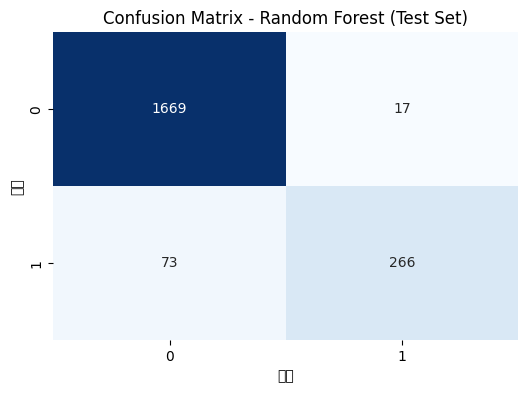

======= Train - Random Forest =======
Accuracy : 1.000000
Precision : 1.000000
Recall : 1.000000
F1 score : 1.000000
auc: 1.000000
======= Test - Random Forest =======
Accuracy : 0.955556
Precision : 0.939929
Recall : 0.784661
F1 score : 0.855305
auc: 0.988702


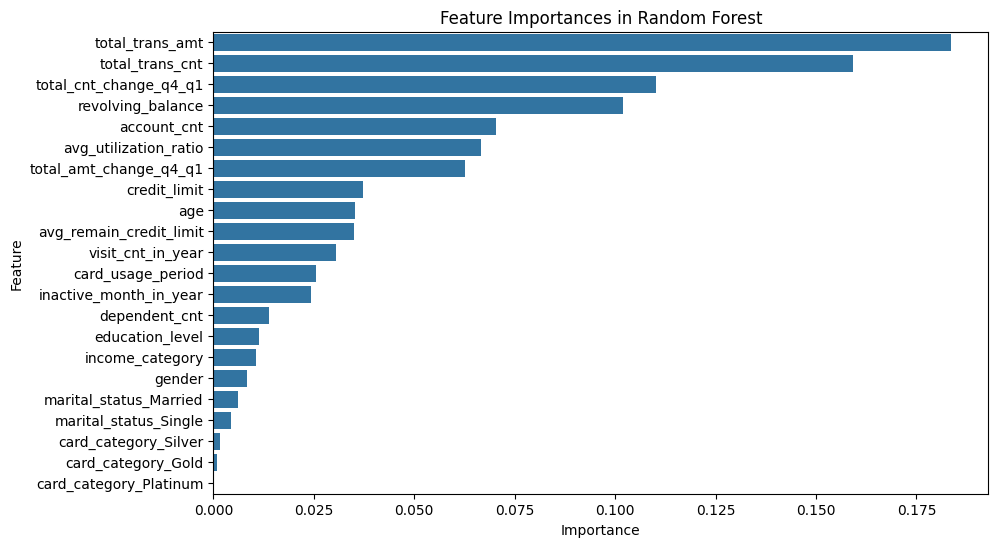

======= Best - Random Forest =======
Accuracy : 0.956049
Precision : 0.946429
Recall : 0.781711
F1 score : 0.856220
auc: 0.989941


In [11]:
# 4-2-2. Random Forest
"""
====================================================================================
주요 파라미터
====================================================================================
- n_estimators: 부스팅 단계의 수 = 모델이 생성할 트리 개수
- max_depth: 각 결정 트리의 최대 깊이를 설정
- max_features: 각 트리가 학습할 때마다 사용할 특성(feature)의 수
"""

from sklearn.ensemble import RandomForestClassifier

# 1. 학습 및 예측
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestClassifier()

rf.fit(X_train, y_train)

# 2. 모델 평가
# Train set + Test set 평가
y_train_pred_rf = rf.predict(X_train)
y_train_proba_rf= rf.predict_proba(X_train)[:, 1]

y_test_pred_rf = rf.predict(X_test)
y_test_proba_rf= rf.predict_proba(X_test)[:, 1]

# 혼동 행렬 시각화 (테스트 데이터)
cm_test = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("예측")
plt.ylabel("정답")
plt.title("Confusion Matrix - Random Forest (Test Set)")
plt.show()

evaluate("Train - Random Forest", y_train, y_train_pred_rf, y_train_proba_rf)
evaluate("Test - Random Forest", y_test, y_test_pred_rf, y_test_proba_rf)

# 3. 특성 중요도 계산 및 시각화
fi = rf.feature_importances_
fi_series = pd.Series(fi, index=df.drop(columns="churn").columns).sort_values(ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=fi_series, y=fi_series.index)
plt.title("Feature Importances in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 4. 최적의 매개변수 구하기 - GridSearchCV
params = {
    'n_estimators': [100, 200, 300],    # 결정 트리(Decision Tree)의 개수
    'max_depth': [5, 10, 15],           # 각 결정 트리의 최대 깊이를 설정
    'max_features': ['sqrt', 'log2']    # 각 트리가 학습할 때마다 사용할 특성(feature)의 수
}
gs_rf = GridSearchCV(
    estimator=rf,       
    param_grid=params,     
    scoring=scoring,
    refit='accuracy',
    cv=5,                      
    n_jobs=-1,             
)

gs_rf.fit(X_train, y_train)

# 5. Best Model: 최적의 하이파라미터로 만든 모델
best_param_rf = gs_rf.best_params_
best_model_rf = gs_rf.best_estimator_

best_y_pred_rf = best_model_rf.predict(X_test)
best_y_proba_rf= best_model_rf.predict_proba(X_test)[:, 1]

# score 기록 
model_box['random_forest'] = evaluate("Best - Random Forest", y_test, best_y_pred_rf, best_y_proba_rf)

C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45813 (\N{HANGUL SYLLABLE DAB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Playdata\AppData\Local\miniconda3\envs\ml\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


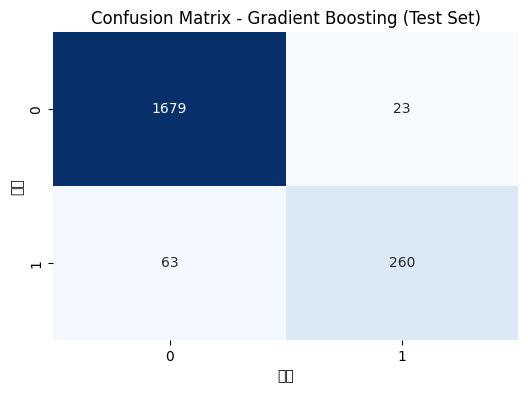

======= Train - Gradient Booting =======
Accuracy : 0.975920
Precision : 0.961699
Recall : 0.885736
F1 score : 0.922156
auc: 0.995351
======= Test - Gradient Booting =======
Accuracy : 0.957531
Precision : 0.918728
Recall : 0.804954
F1 score : 0.858086
auc: 0.985006


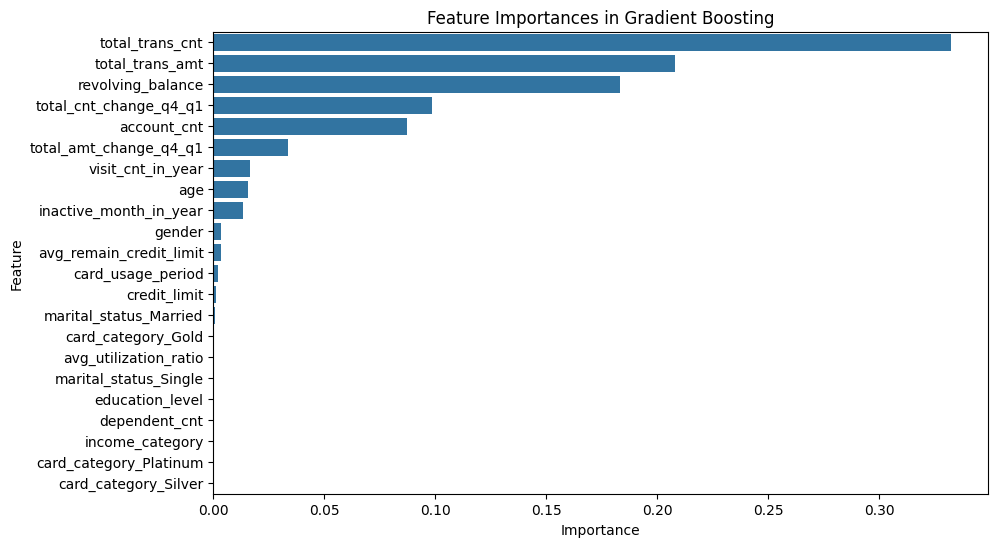

======= Best - Gradient Boosting =======
Accuracy : 0.963457
Precision : 0.908197
Recall : 0.857585
F1 score : 0.882166
auc: 0.990410


In [12]:
# 4-2-3. Gradient Boosting
"""
====================================================================================
주요 파라미터
=======================================================a=============================
- n_estimators: 부스팅 단계의 수 = 모델이 생성할 트리 개수
- learning_rate: 학습률
- max_depth: 각 결정 트리의 최대 깊이를 설정
- subsample: 각 트리 학습에 사용되는 샘플의 비율
"""

from sklearn.ensemble import GradientBoostingClassifier

# 1. 학습 및 예측
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

gb = GradientBoostingClassifier()

gb.fit(X_train, y_train)

# 2. 모델 평가
# Train set + Test set 평가
y_train_pred_gb = gb.predict(X_train)
y_train_proba_gb= gb.predict_proba(X_train)[:, 1]

y_test_pred_gb = gb.predict(X_test)
y_test_proba_gb= gb.predict_proba(X_test)[:, 1]

# 혼동 행렬 시각화 (테스트 데이터)
cm_test = confusion_matrix(y_test, y_test_pred_gb)
plt.figure(figsize=(6,4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("예측")
plt.ylabel("정답")
plt.title("Confusion Matrix - Gradient Boosting (Test Set)")
plt.show()

evaluate("Train - Gradient Booting", y_train, y_train_pred_gb, y_train_proba_gb)
evaluate("Test - Gradient Booting", y_test, y_test_pred_gb, y_test_proba_gb)

# 3. 특성 중요도 계산 및 시각화
fi = gb.feature_importances_
fi_series = pd.Series(fi, index=df.drop(columns="churn").columns).sort_values(ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=fi_series, y=fi_series.index)
plt.title("Feature Importances in Gradient Boosting")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 4. 최적의 매개변수 구하기 - GridSearchCV
params = {
    "n_estimators": [100, 200, 300],  #  부스팅 단계의 수 = 모델이 생성할 트리 개수
    "learning_rate": [0.1],  # 학습률
    "max_depth": [1, 2, 3, 4, 5],  # 각 결정 트리의 최대 깊이를 설정
    "subsample": [0.5, 0.7],  # 샘플링 비율
}

gs_gb = GridSearchCV(
    estimator=gb,           
    param_grid=params,   
    scoring=scoring,
    refit='accuracy',
    cv=5,                  
    n_jobs=-1,            
)

gs_gb.fit(X_train, y_train)

# 5. Best Model: 최적의 하이파라미터로 만든 모델
best_param_gb = gs_gb.best_params_
best_model_gb = gs_gb.best_estimator_

best_y_pred_gb = best_model_gb.predict(X_test)
best_y_proba_gb= best_model_gb.predict_proba(X_test)[:, 1]

# score 기록 
model_box['gradient_boosting'] = evaluate("Best - Gradient Boosting", y_test, best_y_pred_gb, best_y_proba_gb)

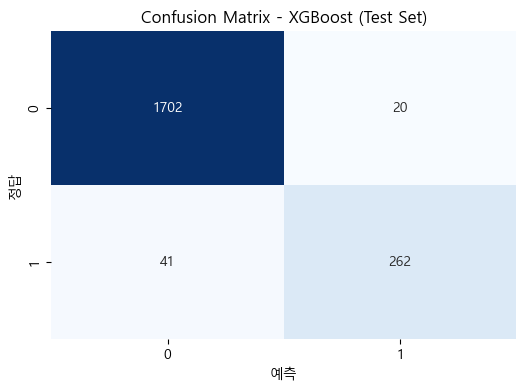

======= Train - XGBoost =======
Accuracy : 1.000000
Precision : 1.000000
Recall : 1.000000
F1 score : 1.000000
auc: 1.000000
======= Test - XGBoost =======
Accuracy : 0.969877
Precision : 0.929078
Recall : 0.864686
F1 score : 0.895726
auc: 0.992339


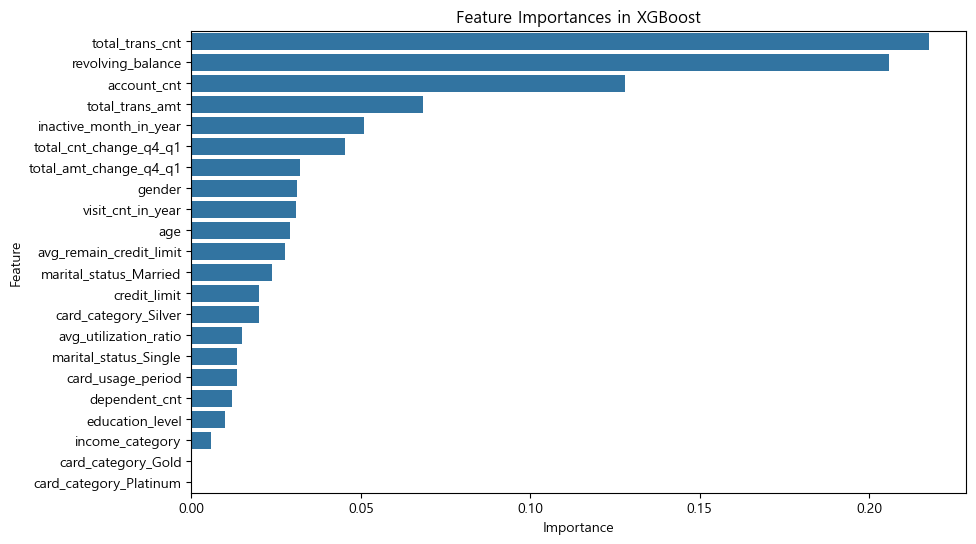

======= Best - XGBoost =======
Accuracy : 0.973333
Precision : 0.933798
Recall : 0.884488
F1 score : 0.908475
auc: 0.991600


In [322]:
# 4-2-4. XGBoost
"""
====================================================================================
주요 파라미터
=======================================================a=============================
  - max_depth: 각 결정 트리의 최대 깊이를 설정
  - learning_rate: 학습률
  - n_estimators: 부스팅 단계의 수 = 모델이 생성할 트리 개수
  - subsample: 각 트리의 훈련에 사용되는 샘플 비율
  - colsample_bytree: 각 트리의 훈련에 사용되는 피처 비율
  - gamma: 노드 분할에 대한 최소 손실 감소
  - reg_alpha: L1 정규화
  - reg_lambda: L2 정규화
"""

from xgboost import XGBClassifier
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

xgb = XGBClassifier()

xgb.fit(X_train, y_train)

# 2. 모델 평가
# Train set + Test set 평가
y_train_pred_xgb = xgb.predict(X_train)
y_train_proba_xgb= xgb.predict_proba(X_train)[:, 1]

y_test_pred_xgb = xgb.predict(X_test)
y_test_proba_xgb= xgb.predict_proba(X_test)[:, 1]

# 혼동 행렬 시각화 (테스트 데이터)
cm_test = confusion_matrix(y_test, y_test_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("예측")
plt.ylabel("정답")
plt.title("Confusion Matrix - XGBoost (Test Set)")
plt.show()

evaluate("Train - XGBoost", y_train, y_train_pred_xgb, y_train_proba_xgb)
evaluate("Test - XGBoost", y_test, y_test_pred_xgb, y_test_proba_xgb)

# 3. 특성 중요도 계산 및 시각화
fi = xgb.feature_importances_
fi_series = pd.Series(fi, index=df.drop(columns="churn").columns).sort_values(ascending=False)

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=fi_series, y=fi_series.index)
plt.title("Feature Importances in XGBoost")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 4. 최적의 매개변수 구하기 - GridSearchCV
params = {
    "max_depth":[1, 2, 3, 4, 5],            # 각 결정 트리의 최대 깊이를 설정
    'learning_rate': [0.1],                 # 학습률
    'n_estimators': [100, 200, 300],        # 부스팅 단계의 수 = 모델이 생성할 트리 개수
    'subsample': [0.5, 0.7],                # 각 트리의 훈련에 사용되는 샘플 비율
    'colsample_bytree': [0.5, 0.7, 1.0],    # 각 트리의 훈련에 사용되는 피처 비율
    'gamma': [0, 0.1],                      # 노드 분할에 대한 최소 손실 감소
    'reg_alpha': [0],                       # L1 정규화
    'reg_lambda': [0.1]                     # L2 정규화
}
gs_xgb = GridSearchCV(
    estimator=xgb,           
    param_grid=params,   
    scoring=scoring,
    refit='accuracy',
    cv=5,                  
    n_jobs=-1,            
)

gs_xgb.fit(X_train, y_train)

# 5. 튜닝 : Best Model 찾기
best_param_xgb = gs_xgb.best_params_
best_model_xgb = gs_xgb.best_estimator_

best_y_pred_xgb = best_model_xgb.predict(X_test)
best_y_proba_xgb= best_model_xgb.predict_proba(X_test)[:, 1]

# score 기록 
model_box['xgboost'] = evaluate("Best - XGBoost", y_test, best_y_pred_xgb, best_y_proba_xgb)

In [324]:
# 5. 평가
# Best Model 의 하이퍼파라미터
print(best_param_tree)
print(best_param_rf)
print(best_param_gb)
print(best_param_xgb)

# Best Model 들의 scoring
model_box




{'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 300}
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.7}
{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.7}


,decision_tree,random_forest,gradient_boosting,xgboost
accuracy,0.945185,0.961975,0.976790,0.973333
precision,0.815152,0.944056,0.964169,0.933798
recall,0.843260,0.815710,0.891566,0.884488
f1 score,0.828968,0.875203,0.926448,0.908475
auc,0.947674,0.991596,0.995335,0.991600


In [ ]:
# 6. 모델 저장
import os
import joblib

# 최적 모델과 하이퍼파라미터 추출
best_models = {
    'DecisionTreeClassifier': best_model_tree,
    'RandomForestClassifier': best_model_rf,
    'GradientBoostingClassifier': best_model_gb,
    'XGBClassifier': best_model_xgb
}

params = {
    'DecisionTreeClassifier': best_model_tree,
    'RandomForestClassifier': best_model_rf,
    'GradientBoostingClassifier': best_model_gb,
    'XGBClassifier': best_model_xgb
}

# 모델과 하이퍼파라미터를 하나의 딕셔너리로 묶어서 저장
model_dict = {
    'models': best_models,
    'params': params
}

import joblib

directory = 'saved/'
os.makedirs(directory, exist_ok=True)

joblib.dump(model_dict, os.path.join(directory, 'models_and_params.joblib'))

# 저장된 모델과 파라미터 불러오기
loaded_model_dict = joblib.load('/saved/models_and_params.joblib')

# 모델과 하이퍼파라미터 출력
print("Loaded Models:", loaded_model_dict['models'])
print("Loaded Params:", loaded_model_dict['params'])

Loaded Models: {'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=30, min_samples_leaf=5, min_samples_split=20), 'RandomForestClassifier': RandomForestClassifier(max_depth=15, n_estimators=300), 'GradientBoostingClassifier': GradientBoostingClassifier(max_depth=4, n_estimators=300, subsample=0.7), 'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n